## Data Exploration

In [1]:
from preprocess_data import get_HITL, get_SWT
import pandas as pd

random_state = 42

# HITL - Network Dataset

In [2]:
hitl_dict = get_HITL(path="../../data/HardwareInTheLoop/", small=True)

In [3]:
for key, value in hitl_dict.items():
    print(key)
    if key.endswith("attack"):
        print("len: ", len(value))

network_dataset_attack
len:  3
network_dataset_normal
physical_dataset_attack
len:  3
physical_dataset_normal


In [4]:
network_dataset_attack = hitl_dict["network_dataset_attack"]
network_dataset_normal = hitl_dict["network_dataset_normal"]
for dataset in [*network_dataset_attack, network_dataset_normal]:
    dataset.rename(columns=lambda x: x.strip().lower(), inplace=True) # remove whitespace from column names

In [5]:
# Check which columns are different between normal and attack
normal_dtypes = network_dataset_normal.dtypes
attack_dtypes = network_dataset_attack[0].dtypes
mask = attack_dtypes == normal_dtypes
print(normal_dtypes[~mask])
print(attack_dtypes[~mask])

sport        int64
dport        int64
flags        int64
n_pkt_src    int64
n_pkt_dst    int64
dtype: object
sport        float64
dport        float64
flags        float64
n_pkt_src    float64
n_pkt_dst    float64
dtype: object


In [6]:
# Update to broader dtype
network_dataset_normal[normal_dtypes[~mask].index] = network_dataset_normal[normal_dtypes[~mask].index].astype("float64")

In [7]:
# Concat whole dataset
network_dataset = pd.concat([*network_dataset_attack, network_dataset_normal], ignore_index=True)
print("Dataset shape: ", network_dataset.shape)
network_dataset.head()

Dataset shape:  (243065, 16)


,time,mac_s,mac_d,ip_s,ip_d,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,modbus_response,label_n,label
0,2021-04-09 18:23:28.430018,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,56666.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,NaN,0,normal
1,2021-04-09 18:23:28.475587,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,502.0,56666.0,Modbus,11000.0,64,Read Coils Response,15.0,50.0,[0],0,normal
2,2021-04-09 18:23:28.523120,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,56668.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,NaN,0,normal
3,2021-04-09 18:23:28.568588,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,[0],0,normal
4,2021-04-09 18:23:28.617394,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,502.0,56666.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,[0],0,normal


## Labels

In [8]:
network_dataset_labels = network_dataset[["label_n", "label"]]
network_dataset = network_dataset.drop(columns=["label_n", "label"])

In [9]:
network_dataset_labels.head()

,label_n,label
0,0,normal
1,0,normal
2,0,normal
3,0,normal
4,0,normal


In [10]:
network_dataset_labels["label_n"].value_counts()

label_n
0    176087
1     66978
Name: count, dtype: int64

Our dataset is unbalanced but the balancing seems to be 1/3.

In [11]:
network_dataset_labels["label"].value_counts()

label
normal            176087
DoS                37665
MITM               16841
physical fault     12469
anomaly                3
Name: count, dtype: int64

We have 5 labels: normal, DoS, MITM, physical fault, anomaly.
More imporantly the data is also split is normal (label_n=0) or not normal (label_n=1).

Now let's look at the features

In [12]:
network_dataset.head()

,time,mac_s,mac_d,ip_s,ip_d,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,modbus_response
0,2021-04-09 18:23:28.430018,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,56666.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,NaN
1,2021-04-09 18:23:28.475587,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,502.0,56666.0,Modbus,11000.0,64,Read Coils Response,15.0,50.0,[0]
2,2021-04-09 18:23:28.523120,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,56668.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,NaN
3,2021-04-09 18:23:28.568588,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,[0]
4,2021-04-09 18:23:28.617394,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,502.0,56666.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,[0]


As we can see we have 14 features.

In [13]:
# Convert time to timestamp
network_dataset["time"] = pd.to_datetime(network_dataset["time"], format="mixed")
network_dataset["time"] = network_dataset["time"].apply(lambda x: x.timestamp())

In [14]:
network_dataset["time"].head()

0    1.617993e+09
1    1.617993e+09
2    1.617993e+09
3    1.617993e+09
4    1.617993e+09
Name: time, dtype: float64

In [15]:
print(len(network_dataset.columns))

14


In [16]:
print(network_dataset.dtypes)
print("Number of string columns: ", (network_dataset.dtypes == "object").sum())

time               float64
mac_s               object
mac_d               object
ip_s                object
ip_d                object
sport              float64
dport              float64
proto               object
flags              float64
size                 int64
modbus_fn           object
n_pkt_src          float64
n_pkt_dst          float64
modbus_response     object
dtype: object
Number of string columns:  7


We have 7 categorical features and 7 numerical features.

## Numerical Features

In [17]:
network_dataset_numeric = network_dataset.select_dtypes(exclude=["object"])
network_dataset_numeric.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0


In [18]:
network_dataset_numeric.describe()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst
count,2.430650e+05,208564.000000,208564.000000,208564.000000,243065.000000,243056.000000,243056.000000
mean,1.618168e+09,29935.053614,29827.705903,10902.935909,236.671434,39.752514,39.561961
std,3.528267e+05,29495.006844,29513.480383,928.439179,467.620917,28.052526,27.835061
min,1.617968e+09,502.000000,502.000000,10.000000,60.000000,0.000000,0.000000
25%,1.617971e+09,502.000000,502.000000,11000.000000,65.000000,15.000000,15.000000
50%,1.617995e+09,33321.000000,502.000000,11000.000000,66.000000,44.000000,44.000000
75%,1.617998e+09,61317.000000,61317.000000,11000.000000,66.000000,50.000000,50.000000
max,1.618849e+09,61646.000000,61646.000000,11000.000000,1514.000000,100.000000,100.000000


We will have to normalize the numerical features.

In [19]:
# Get the number of nan values per column
network_dataset_numeric.isna().sum()

time             0
sport        34501
dport        34501
flags        34501
size             0
n_pkt_src        9
n_pkt_dst        9
dtype: int64

We have got quite a few NaN values on the columns sport, dport and flags. They have around 12% of NaN values.

## Categorical Features

In [20]:
network_dataset_categorical = network_dataset.select_dtypes(include="object")
network_dataset_categorical.head()

,mac_s,mac_d,ip_s,ip_d,proto,modbus_fn,modbus_response
0,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,NaN
1,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Coils Response,[0]
2,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,NaN
3,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,Modbus,Read Holding Registers Response,[0]
4,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Holding Registers Response,[0]


In [21]:
network_dataset_categorical.isna().sum()

mac_s                   0
mac_d                   0
ip_s                    9
ip_d                    9
proto                   0
modbus_fn           40456
modbus_response    141683
dtype: int64

We only have 9 rows that have NaN values in the categorical features if we excluse modbus_fn and modbus_response.

modbus_fn and modbus_response are both categorical features that have a lot of NaN values (respectively 15% and 50%)

We will surely have to drop modbus_response but we will see later if we can do something with modbus_fn.

In [22]:
network_dataset_categorical["mac_s"].value_counts()

mac_s
74:46:a0:bd:a7:1b    100892
00:0c:29:47:8c:22     34633
e6:3f:ac:c9:a8:8c     32424
0a:fe:ec:47:74:fb     32165
fa:00:bc:90:d7:fa     31543
00:80:f4:03:fb:12     10266
4a:35:83:e0:3d:a4       602
fe:bb:16:7b:c3:27       540
Name: count, dtype: int64

In [23]:
network_dataset_categorical["mac_d"].value_counts()

mac_d
74:46:a0:bd:a7:1b    102998
00:80:f4:03:fb:12     43357
e6:3f:ac:c9:a8:8c     32137
0a:fe:ec:47:74:fb     31956
fa:00:bc:90:d7:fa     31564
4a:35:83:e0:3d:a4       437
fe:bb:16:7b:c3:27       428
00:0c:29:47:8c:22       185
ff:ff:ff:ff:ff:ff         3
Name: count, dtype: int64

In [24]:
network_dataset_categorical["ip_s"].value_counts()

ip_s
84.3.251.20     105704
84.3.251.101     32681
84.3.251.102     32193
84.3.251.103     31559
84.3.251.110     29501
84.3.251.18      10271
84.3.251.104       607
84.3.251.105       540
Name: count, dtype: int64

In [25]:
network_dataset_categorical["ip_d"].value_counts()


ip_d
84.3.251.20     102996
84.3.251.18      43366
84.3.251.101     32155
84.3.251.102     31987
84.3.251.103     31572
84.3.251.104       441
84.3.251.105       428
84.3.251.110       111
Name: count, dtype: int64

In [26]:
network_dataset_categorical["proto"].value_counts()

proto
Modbus    202609
IP         27986
ICMP        6506
TCP         5955
ARP            9
Name: count, dtype: int64

In [27]:
network_dataset_categorical["modbus_fn"].value_counts()

modbus_fn
Read Holding Registers Response    57546
Read Holding Registers             57313
Read Coils Request                 43914
Read Coils Response                43836
Name: count, dtype: int64

As there are few possibilities for this column, maybe we will be able to make use of it even if it has ~25% of nan values.

In [28]:
network_dataset_categorical["modbus_response"].value_counts()

modbus_response
[0]       61171
[1]        9482
[4000]     4709
[458]       664
[450]       354
          ...  
[1182]        1
[1134]        1
[940]         1
[892]         1
[811]         1
Name: count, Length: 1933, dtype: int64

As this column is very sparse and has more than 50% nans, it seems that we should drop it.

We can see that most of our categorical features have <10 unique values.

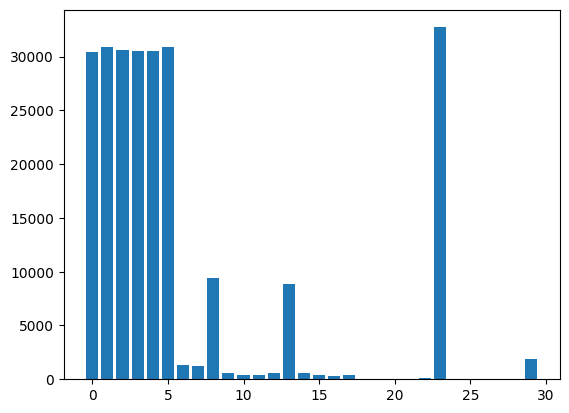

In [29]:
import matplotlib.pyplot as plt

def get_hist_pairs_per_column(col_name_1, col_name_2):
    # Sum each identical pair of ip addresses
    ip_pairs_count = {}
    for i, row in network_dataset_categorical.iterrows():
        ip_pair = (row[col_name_1], row[col_name_2])
        if ip_pair in ip_pairs_count:
            ip_pairs_count[ip_pair] += 1
        else:
            ip_pairs_count[ip_pair] = 1

    # Numerize each pair to print it on a graph
    ip_pairs_count_numerized = {}
    for i, (key, value) in enumerate(ip_pairs_count.items()):
        ip_pairs_count_numerized[i] = value

    # Plot the histogram
    plt.bar(ip_pairs_count_numerized.keys(), ip_pairs_count_numerized.values())

get_hist_pairs_per_column("mac_s", "mac_d")

We have around 30 pairs of (mac_s, mac_d) that are unique.

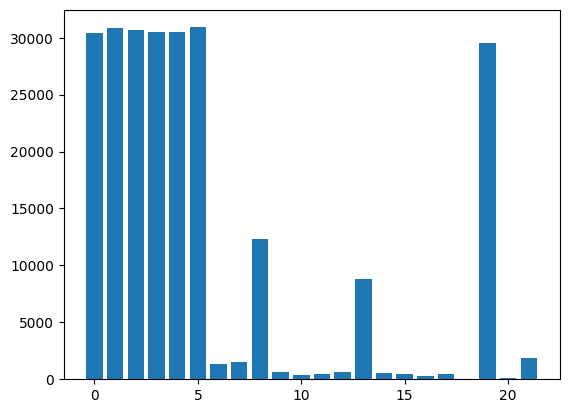

In [30]:
get_hist_pairs_per_column("ip_s", "ip_d")


We have around 21 pairs of (ip_s, ip_d) that are unique.

# HITL - Physical Dataset

In [31]:
physical_dataset_attack = hitl_dict["physical_dataset_attack"]
physical_dataset_normal = hitl_dict["physical_dataset_normal"]
for dataset in [*physical_dataset_attack, physical_dataset_normal]:
    dataset.rename(columns=lambda x: x.strip().lower(), inplace=True) # remove whitespace from column names

In [32]:
# Check which columns are different between normal and attack
normal_dtypes = network_dataset_normal.dtypes
attack_dtypes = network_dataset_attack[0].dtypes
mask = attack_dtypes == normal_dtypes
print(normal_dtypes[~mask])
print(attack_dtypes[~mask])

Series([], dtype: object)
Series([], dtype: object)


All columns are ready to be concatenated.

In [33]:
physical_dataset = pd.concat([*physical_dataset_attack, physical_dataset_normal], ignore_index=True)
# Convert time to timestamp
physical_dataset["time"] = pd.to_datetime(physical_dataset["time"], format="mixed")
physical_dataset["time"] = physical_dataset["time"].apply(lambda x: x.timestamp())

print("Dataset shape: ", physical_dataset.shape)
physical_dataset.head()

Dataset shape:  (91, 44)


,time,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,...,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22,label_n,label,lable_n
0,1.630780e+09,1501,1844,306,0,522,0,0,0,False,...,False,True,False,False,False,False,False,0.0,normal,NaN
1,1.630780e+09,1,552,1180,1054,486,329,0,0,False,...,False,True,False,False,True,False,False,1.0,MITM,NaN
2,1.630780e+09,671,3,360,24,0,703,112,0,False,...,False,False,False,False,False,False,False,0.0,normal,NaN
3,1.630780e+09,1167,1922,112,24,805,20,458,337,False,...,False,True,False,False,False,False,False,0.0,normal,NaN
4,1.630780e+09,1,4,1632,785,423,6,458,402,False,...,False,False,False,False,True,False,False,0.0,normal,NaN


In [34]:
# There is a third column named lable_n which seems to be the same as label_n
physical_label_n = physical_dataset["label_n"]
physical_lable_n = physical_dataset["lable_n"]

# Print both column's respective non NaN indexes to see if they are complementary
physical_label_n_indexes = physical_label_n[~physical_label_n.isna()].index
physical_lable_n_indexes = physical_lable_n[~physical_lable_n.isna()].index
print(physical_label_n_indexes)
print(physical_lable_n_indexes)
assert len(set(physical_label_n_indexes).intersection(set(physical_lable_n_indexes))) == 0 # Both columns are complementary

# Merge the two columns
physical_dataset["label_n"] = physical_label_n.fillna(physical_lable_n)

assert physical_dataset["label_n"].isna().sum() == 0

physical_dataset = physical_dataset.drop(columns=["lable_n"])

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
      dtype='int64')
Index([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44],
      dtype='int64')


On the physical dataset we have we have much more features (41 if we exclude the two label columns as before). 

However, we have much less rows (91, which is very small).

## Labels

In [35]:
physical_dataset_labels = physical_dataset[["label_n", "label"]]
physical_dataset = physical_dataset.drop(columns=["label_n", "label"])

In [36]:
physical_dataset_labels.head()

,label_n,label
0,0.0,normal
1,1.0,MITM
2,0.0,normal
3,0.0,normal
4,0.0,normal


In [37]:
physical_dataset_labels["label_n"].value_counts()

label_n
0.0    75
1.0    16
Name: count, dtype: int64

In [38]:
physical_dataset_labels["label"].value_counts()

label
normal            73
MITM               7
physical fault     5
DoS                3
nomal              2
scan               1
Name: count, dtype: int64

In [39]:
# Two rows have typos in their label from "normal" to "nomal" let's fix that
physical_dataset_labels.loc[physical_dataset_labels["label"] == "nomal", "label"] = "normal"
physical_dataset_labels["label"].value_counts()

label
normal            75
MITM               7
physical fault     5
DoS                3
scan               1
Name: count, dtype: int64

We have 5 labels: normal, DoS, MITM, physical fault, anomaly.
More imporantly the data is also split is normal (label_n=0) or not normal (label_n=1).

Two things are of note:
- It is the same labels as the network dataset
- This dataset is strongly unbalanced (we have 75 normal rows and 16 abnormal rows)

Now let's look at the features

In [40]:
physical_dataset.head()

,time,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,...,valv_13,valv_14,valv_15,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22
0,1.630780e+09,1501,1844,306,0,522,0,0,0,False,...,False,False,False,False,True,False,False,False,False,False
1,1.630780e+09,1,552,1180,1054,486,329,0,0,False,...,True,True,True,False,True,False,False,True,False,False
2,1.630780e+09,671,3,360,24,0,703,112,0,False,...,False,False,False,False,False,False,False,False,False,False
3,1.630780e+09,1167,1922,112,24,805,20,458,337,False,...,False,False,False,False,True,False,False,False,False,False
4,1.630780e+09,1,4,1632,785,423,6,458,402,False,...,True,True,True,False,False,False,False,True,False,False


In [41]:
physical_dataset.dtypes.value_counts()

bool       28
int64      12
float64     1
Name: count, dtype: int64

In [42]:
physical_dataset.isna().sum().any()

False

As we can see our dataset doesn't have any NaN values.

## Boolean features

In [43]:
bool_mask = physical_dataset.dtypes == "bool"
physical_dataset_bool = physical_dataset.loc[:, bool_mask]
physical_dataset_bool.head()

,pump_1,pump_2,pump_3,pump_4,pump_5,pump_6,valv_1,valv_2,valv_3,valv_4,...,valv_13,valv_14,valv_15,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,False,True,False,False,True,False,False
2,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,True,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,False,False,False,False,True,True,False,False,False,False,...,True,True,True,False,False,False,False,True,False,False


In [44]:
# Proportion of True values per column
physical_dataset_bool.sum() * 100 / len(physical_dataset_bool)

pump_1     32.967033
pump_2     21.978022
pump_3      0.000000
pump_4     23.076923
pump_5     37.362637
pump_6     38.461538
valv_1      0.000000
valv_2      0.000000
valv_3      0.000000
valv_4      0.000000
valv_5      0.000000
valv_6      0.000000
valv_7      0.000000
valv_8      0.000000
valv_9      0.000000
valv_10    61.538462
valv_11    61.538462
valv_12    61.538462
valv_13    40.659341
valv_14    40.659341
valv_15    40.659341
valv_16     0.000000
valv_17    54.945055
valv_18    18.681319
valv_19     0.000000
valv_20    63.736264
valv_21     0.000000
valv_22    46.153846
dtype: float64

Here we can see that 13 columns are all False which means that they are useless.

## Int Features

In [45]:
int_mask = physical_dataset.dtypes == "int64"
physical_dataset_int = physical_dataset.loc[:, int_mask]
physical_dataset_int.head()

,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,flow_sensor_1,flow_sensor_2,flow_sensor_3,flow_sensor_4
0,1501,1844,306,0,522,0,0,0,0,0,0,0
1,1,552,1180,1054,486,329,0,0,0,0,0,0
2,671,3,360,24,0,703,112,0,4000,0,0,0
3,1167,1922,112,24,805,20,458,337,4000,4000,0,0
4,1,4,1632,785,423,6,458,402,4000,4000,0,0


In [46]:
physical_dataset_int.describe()

,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,flow_sensor_1,flow_sensor_2,flow_sensor_3,flow_sensor_4
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.0,91.000000
mean,684.681319,958.835165,597.461538,289.142857,375.956044,205.373626,186.351648,172.406593,1495.604396,1538.461538,0.0,1426.131868
std,675.386751,696.886732,631.855632,353.013017,278.330056,177.427459,195.858247,183.934770,1944.959987,1956.798362,0.0,1825.951869
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,3.500000,6.000000,123.500000,24.500000,50.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,614.000000,1043.000000,397.000000,34.000000,458.000000,200.000000,128.000000,91.000000,0.000000,0.000000,0.0,0.000000
75%,1322.500000,1604.000000,955.500000,530.500000,585.000000,385.500000,401.500000,368.000000,4000.000000,4000.000000,0.0,3155.000000
max,2015.000000,1953.000000,3427.000000,1061.000000,837.000000,703.000000,659.000000,487.000000,4000.000000,4000.000000,0.0,4733.000000


- The column flow_sensor_3 seems useless as it has only one value (0)
- The other data will be normalized

In [47]:
# Check correlation between all the flow_sensor_ columns
physical_dataset_int[[f"flow_sensor_{i}"  for i in range(1, 5)]].corr()

,flow_sensor_1,flow_sensor_2,flow_sensor_3,flow_sensor_4
flow_sensor_1,1.000000,-0.050753,NaN,-0.489373
flow_sensor_2,-0.050753,1.000000,NaN,0.303340
flow_sensor_3,NaN,NaN,NaN,NaN
flow_sensor_4,-0.489373,0.303340,NaN,1.000000


## Float Features

In [48]:
float_mask = physical_dataset.dtypes == "float64"
physical_dataset_float = physical_dataset.loc[:, float_mask]
physical_dataset_float.head()

,time
0,1.630780e+09
1,1.630780e+09
2,1.630780e+09
3,1.630780e+09
4,1.630780e+09


Our only float feature is the column time.

# SWT

## Part 1

## Part 2

## Part 3

## Part 4